In [32]:
import os
import numpy as np
from dask import persist
import dask.dataframe as df
from operator import add
from dask.distributed import Client
import matplotlib.pyplot as plt
from functools import reduce
import geopandas as gpd

head, tail = os.path.split(os.getcwd())
data_dir = os.path.join(head, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')

In [2]:
from dask.distributed import Client

client = Client() # "tcp://127.0.0.1:58293"
client

Client Scheduler: tcp://127.0.0.1:52308 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
def assignCentroid(row, centroids):
    c = reduce((lambda a,b: a if a[1]<b[1] else b),[(centroids.name,(row.nLongitude-centroids.nLongitude)**2 + (row.nLatitude-centroids.nLatitude)**2) for centroids in centroids.itertuples()]) 
    return  c[0]

# Loading data

In [4]:
park_spot_data = df.read_csv(os.path.join(data_raw_dir, 'Places.csv'), 
                             encoding='cp1252', blocksize='512KiB')[['sNoPlace','nLongitude','nLatitude']]

list_of_borough =['Plateau-Mont-Royal',
                  'Saint-Léonard',
                  'Rosemont - La Petite-Patrie',
                  'Outremont',
                  'Ville-Marie',
                  'Mercier - Hochelaga-Maisonneuve',
                  'LaSalle',
                  'Villeray - Saint-Michel - Parc-Extension',
                  'Rivière-des-Prairies - Pointe-aux-Trembles',
                  'Côte-des-Neiges - Notre-Dame-de-Grâce',
                  'Lachine',
                  'Saint-Laurent',
                  'Ahuntsic - Cartierville',
                  'Sud-Ouest',
                  'Anjou',
                  'Montréal-Nord',
                  'Verdun',
                  'Pierrefonds - Roxboro']


# Initializing centroids randomly

In [5]:
init_centroids = park_spot_data.sample(frac=0.002).head(len(list_of_borough),npartitions=-1)

In [6]:
centroids = init_centroids.reset_index(drop=True).rename(columns={'sNoPlace':'name'})

In [7]:
park_spot_data['centroids']=''
epoch=0

# Fitting loop

In [8]:
while True:
    epoch+=1
    park_spot_data['new_centroids'] = park_spot_data.apply(assignCentroid, axis=1, args=(centroids,), meta=('centroid', 'f8'))
    park_spot_data = park_spot_data.persist()
    spot_changed_number =len(park_spot_data[park_spot_data['centroids']!=park_spot_data['new_centroids']])
    print('Epoch ',epoch,':',spot_changed_number)
    if spot_changed_number==0:
        break
    centroids = park_spot_data[['nLongitude','nLatitude','new_centroids']].groupby('new_centroids').mean().reset_index().rename(columns={'new_centroids':'name'})
    centroids = centroids.persist()
    park_spot_data['centroids']=park_spot_data['new_centroids']
    

Epoch  1 : 18652
Epoch  2 : 3092
Epoch  3 : 2251
Epoch  4 : 1396
Epoch  5 : 1296
Epoch  6 : 1145
Epoch  7 : 1073
Epoch  8 : 850
Epoch  9 : 814
Epoch  10 : 677
Epoch  11 : 607
Epoch  12 : 487
Epoch  13 : 394
Epoch  14 : 314
Epoch  15 : 299
Epoch  16 : 263
Epoch  17 : 187
Epoch  18 : 192
Epoch  19 : 178
Epoch  20 : 173
Epoch  21 : 159
Epoch  22 : 149
Epoch  23 : 125
Epoch  24 : 113
Epoch  25 : 107
Epoch  26 : 100
Epoch  27 : 75
Epoch  28 : 71
Epoch  29 : 83
Epoch  30 : 80
Epoch  31 : 74
Epoch  32 : 74
Epoch  33 : 76
Epoch  34 : 57
Epoch  35 : 54
Epoch  36 : 57
Epoch  37 : 41
Epoch  38 : 33
Epoch  39 : 44
Epoch  40 : 52
Epoch  41 : 52
Epoch  42 : 58
Epoch  43 : 55
Epoch  44 : 48
Epoch  45 : 45
Epoch  46 : 34
Epoch  47 : 28
Epoch  48 : 17
Epoch  49 : 17
Epoch  50 : 13
Epoch  51 : 13
Epoch  52 : 13
Epoch  53 : 25
Epoch  54 : 33
Epoch  55 : 27
Epoch  56 : 31
Epoch  57 : 28
Epoch  58 : 26
Epoch  59 : 34
Epoch  60 : 49
Epoch  61 : 84
Epoch  62 : 112
Epoch  63 : 124
Epoch  64 : 111
Epoch  65 : 

# Plotting the result

In [16]:
# groups = park_spot_data.groupby('centroids')
# groups.head()
# for name, group in groups:
#     plt.plot(group.nLongitude, group.nLatitude, marker='.', linestyle='',  label=name)


KeyError: 'Column not found: 0'

In [19]:
parking_spots = park_spot_data.compute()

In [21]:
parking_spots.head()

,sNoPlace,nLongitude,nLatitude,centroids,new_centroids
0,A007,-73.581856,45.489593,D612,D612
1,A008,-73.581856,45.489593,D612,D612
2,A009,-73.581727,45.489532,D612,D612
3,A010,-73.581727,45.489532,D612,D612
4,A011,-73.581597,45.489471,D612,D612


In [24]:
parking_spots_geo = gpd.GeoDataFrame(parking_spots, geometry=gpd.points_from_xy(parking_spots.nLongitude, parking_spots.nLatitude))
parking_spots_geo

,sNoPlace,nLongitude,nLatitude,centroids,new_centroids,geometry
0,A007,-73.581856,45.489593,D612,D612,POINT (-73.58186 45.48959)
1,A008,-73.581856,45.489593,D612,D612,POINT (-73.58186 45.48959)
2,A009,-73.581727,45.489532,D612,D612,POINT (-73.58173 45.48953)
3,A010,-73.581727,45.489532,D612,D612,POINT (-73.58173 45.48953)
4,A011,-73.581597,45.489471,D612,D612,POINT (-73.58160 45.48947)
...,...,...,...,...,...,...
2213,Z981,-73.625708,45.472290,A975,A975,POINT (-73.62571 45.47229)
2214,Z982,-73.625622,45.472384,A975,A975,POINT (-73.62562 45.47238)
2215,Z991,-73.625225,45.472819,A975,A975,POINT (-73.62522 45.47282)
2216,Z992,-73.625182,45.472864,A975,A975,POINT (-73.62518 45.47286)


In [25]:
boroughs = gpd.read_file(os.path.join(data_raw_dir, 'montreal_boroughs.geojson'))

Text(0.5, 1.0, 'Towing in the year')

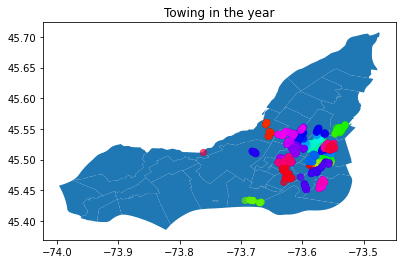

In [41]:
fig, ax = plt.subplots(1, figsize=(8, 4))
boroughs.plot(ax=ax)
parking_spots_geo.plot(ax=ax, marker='o', cmap = "hsv", alpha=0.075, label='centroids')
plt.title('Towing in the year')
# plt.savefig(os.path.join(RPT_FIGURES_DIR, output_filename))

In [29]:


parking_spots_geo['centroids'].unique()

array(['D612', 'AC407', 'E541', 'M411', 'M753', 'N250', 'M566', 'L832',
       'A975', 'MA616', 'PD346', 'G762', 'PF492', 'H175', 'PL400',
       'PJ330', 'B816', 'A726'], dtype=object)